<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/rasterio_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# rtree and pygeos are required for geopandas.overlay
!pip install rasterio geopandas rtree pygeos

     |████████████████████████████████| 19.3 MB 1.5 MB/s 
     |████████████████████████████████| 1.0 MB 42.0 MB/s 
     |████████████████████████████████| 1.0 MB 40.7 MB/s 
     |████████████████████████████████| 2.1 MB 50.2 MB/s 
     |████████████████████████████████| 6.3 MB 37.7 MB/s 
     |████████████████████████████████| 16.7 MB 45.6 MB/s 


In [2]:
!git clone https://github.com/simonkassel/python-satellite-imagery-workshop.git

Cloning into 'python-satellite-imagery-workshop'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 79 (delta 5), reused 11 (delta 2), pack-reused 58
Unpacking objects: 100% (79/79), done.


## Why Rasterio and Not GDAL?
- rasterio is python API for GDAL's C++ backend
- it manages many of gotchas around GDAL python bindings
https://rasterio.readthedocs.io/en/latest/intro.html
https://gdal.org/api/python.html

## Basics

In [4]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
import os
project_dir = 'python-satellite-imagery-workshop'

In [11]:
!head -n 50 python-satellite-imagery-workshop/buildings.geojson

{
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:EPSG::32636"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "condition": "good",
                "material": "cement_block"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            459626.5961106891,
                            28121.568562214343
                        ],
                        [
                            459626.8635116092,
                            28133.594468839576
                        ],
                        [
                            459635.69885682187,
                            28134.35689317324
                        ],
                        [
                            459635.2088325734,
                         

Vector Data = Points, Lines and Polygons
online tool geojson.io -> allows to make a polygon


In [12]:
buildings = gpd.read_file(f'{project_dir}/buildings.geojson')
buildings.head()

,condition,material,geometry
0,good,cement_block,"POLYGON ((459626.596 28121.569, 459626.864 281..."
1,good,concrete,"POLYGON ((459416.838 28816.900, 459436.701 288..."
2,good,cement_block,"POLYGON ((459415.913 28385.227, 459426.062 283..."
3,good,cement_block,"POLYGON ((459402.927 28369.620, 459400.112 283..."
4,good,cement_block,"POLYGON ((459410.038 28399.796, 459413.944 283..."


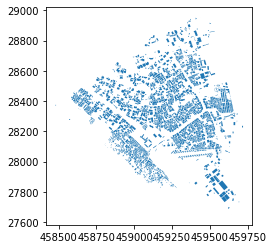

In [13]:
buildings.plot()

In [16]:
b1 = buildings['geometry'].loc[1]

In [21]:
b1.centroid.xy # centroid of building 

(array('d', [459431.05230464344]), array('d', [28805.71192215209]))

In [18]:
b1.area

664.0568703581537

 ### CRS 
 Choose a coordinate system which makes sense for your area of study and which minimizes the error the most for your application
 https://epsg.io/32636

In [22]:
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Raster Data

### stored in tif file because Metadata is built into file
- you will loose the metadata after conversion into png

In [25]:
!gdalinfo python-satellite-imagery-workshop/img.tif

Driver: GTiff/GeoTIFF
Files: python-satellite-imagery-workshop/img.tif
Size is 6000, 6000
Coordinate System is:
PROJCS["WGS 84 / UTM zone 36N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",33],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32636"]]
Origin = (459286.620712036266923,28083.912440528732986)
Pixel Size = (0.035334835417146,-0.035334911276513)
Metadata:
  A

### Note - Missing Data
Alpha Band refers to missing data (TODO: Read more)

In [77]:
with rasterio.open(f'{project_dir}/img.tif', 'r') as src:
    img = src.read() # 2D array of RGB values, one element in array = one pixel
img

array([[[ 93,  97, 101, ..., 140, 139, 143],
        [100,  95,  91, ..., 163, 162, 166],
        [ 97,  87,  85, ..., 164, 165, 169],
        ...,
        [107, 104, 102, ..., 191, 182, 179],
        [109, 104, 101, ..., 148, 181, 164],
        [ 96,  93,  94, ...,  83, 125, 138]],

       [[ 97,  96,  95, ..., 124, 122, 125],
        [103,  96,  90, ..., 146, 146, 151],
        [ 98,  90,  88, ..., 147, 150, 156],
        ...,
        [122, 119, 117, ..., 180, 173, 173],
        [124, 119, 116, ..., 135, 170, 155],
        [111, 108, 109, ...,  62, 105, 118]],

       [[ 61,  62,  62, ...,  98,  96,  98],
        [ 66,  60,  57, ..., 121, 121, 125],
        [ 61,  54,  54, ..., 124, 126, 131],
        ...,
        [ 57,  54,  52, ..., 164, 167, 161],
        [ 59,  54,  51, ..., 113, 157, 140],
        [ 46,  43,  44, ...,  37,  86,  99]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..

In [30]:
img.shape # (bands, pixel_h, pixel_w)

(4, 6000, 6000)

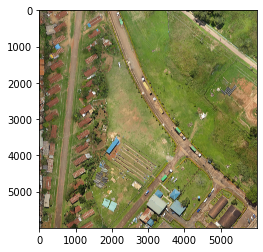

In [31]:
plt.imshow(img.T)

## Windowed reading

In [33]:
with rasterio.open(f'{project_dir}/img.tif') as src:
    width = src.width
    height = src.height
    p = src.profile.copy()

In [34]:
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6000, 'height': 6000, 'count': 4, 'crs': CRS.from_epsg(32636), 'transform': Affine(0.03533483541714589, 0.0, 459286.62071203627,
       0.0, -0.035334911276512705, 28083.912440528733), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'jpeg', 'interleave': 'pixel'}

#### Extract 1000x1000 center square from image

In [35]:
aoi_h = 1000
aoi_w = aoi_h
row_start = height/2 - (aoi_h/2)
col_start = width/2 - (aoi_w/2)

In [36]:
print(row_start, col_start)

2500.0 2500.0


In [37]:
pprint(p['transform'])

Affine(0.03533483541714589, 0.0, 459286.62071203627,
       0.0, -0.035334911276512705, 28083.912440528733)


In [39]:
from rasterio.features import Window
from rasterio.windows import bounds
win = Window(col_off=col_start, row_off=row_start, width=1000, height=1000)

In [40]:
# Create transform for the window
x = rasterio.open(f'{project_dir}/img.tif').window_transform(win)
x

Affine(0.03533483541714589, 0.0, 459374.95780057914,
       0.0, -0.035334911276512705, 27995.575162337453)

In [42]:
2500*0.03533483541714589 + 459286.62071203627
28083.912440528733 - 2500*0.03533483541714589

27995.57535198587

In [44]:
with rasterio.open(f'{project_dir}/img.tif') as src:
    f = src.read(window=win) # reads the center portion of the image
    # copy relevant metadata from source image
    p = src.profile.copy()
    p['width'] = win.width 
    p['height'] = win.height
    p['transform'] = src.window_transform(win)


In [45]:
f.shape

(4, 1000, 1000)

In [46]:
with rasterio.open('sample.tif', 'w', **p) as dst:
    dst.write(f)

In [49]:
with rasterio.open(f'sample.tif', 'r') as src:
    img = src.read() # 2D array of RGB values, one element in array = one pixel
img.T.shape # transposes array shape

(1000, 1000, 4)

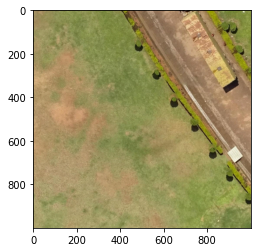

In [50]:
plt.imshow(img.T)

# Processing Data for ML

In [51]:
buildings

,condition,material,geometry
0,good,cement_block,"POLYGON ((459626.596 28121.569, 459626.864 281..."
1,good,concrete,"POLYGON ((459416.838 28816.900, 459436.701 288..."
2,good,cement_block,"POLYGON ((459415.913 28385.227, 459426.062 283..."
3,good,cement_block,"POLYGON ((459402.927 28369.620, 459400.112 283..."
4,good,cement_block,"POLYGON ((459410.038 28399.796, 459413.944 283..."
...,...,...,...
3924,poor,brick,"POLYGON ((459145.088 27926.680, 459146.067 279..."
3925,poor,metal;wood,"POLYGON ((459021.426 27916.217, 459024.475 279..."
3926,average,brick,"POLYGON ((459066.106 28001.690, 459067.697 280..."
3927,poor,brick,"POLYGON ((459019.915 27994.109, 459021.740 279..."


In [75]:
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Patching image into grid

In [79]:
with rasterio.open(f'{project_dir}/img.tif') as src:
    bounds = src.bounds
    img_crs=src.crs

In [80]:
img_crs

CRS.from_epsg(32636)

In [81]:
bounds
l,b,r,t = bounds

## Clip buildings dataset to img dataset

In [82]:
from shapely.geometry import Polygon


In [83]:
img_bbox = Polygon([(l, b), (l, t), (r, t), (r, b)])

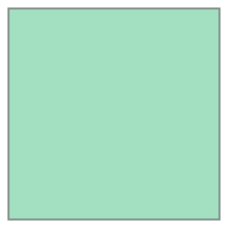

In [84]:
img_bbox

In [85]:
#TODO Plot bounding box on the image

In [86]:
bbox_gdf = gpd.GeoDataFrame({'geometry': [img_bbox]}, crs=img_crs) # Force the geometry into gdf so its easy to concat with buildings

In [87]:
bbox_gdf

,geometry
0,"POLYGON ((459286.621 27871.903, 459286.621 280..."


In [93]:
buildings.to_file('buildings.shp')

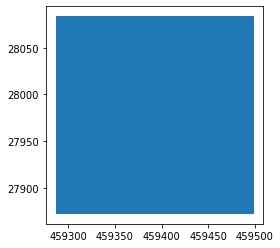

In [88]:
bbox_gdf.plot()

In [89]:
bldgs = gpd.overlay(buildings, bbox_gdf, how='intersection') # finds the intersection of buildings and bbox

In [90]:
bldgs

,condition,material,geometry
0,good,cement_block;metal;brick,"POLYGON ((459484.914 27919.343, 459489.543 279..."
1,good,cement_block;metal;brick,"POLYGON ((459492.714 27909.925, 459498.630 279..."
2,good,concrete;metal,"POLYGON ((459491.891 27915.739, 459498.630 279..."
3,good,concrete;cement_block;stone,"POLYGON ((459487.408 27967.070, 459477.270 279..."
4,average,brick,"POLYGON ((459389.164 28042.224, 459381.697 280..."
...,...,...,...
81,average,brick,"POLYGON ((459456.921 28081.903, 459460.504 280..."
82,average,cement_block,"POLYGON ((459449.009 28082.158, 459444.314 280..."
83,average,brick,"POLYGON ((459438.549 28082.678, 459438.850 280..."
84,average,brick,"POLYGON ((459437.570 28083.617, 459436.213 280..."


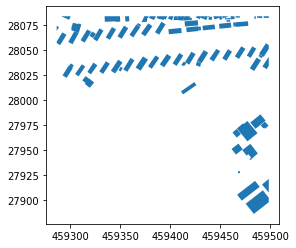

In [91]:
bldgs.plot()